# Graduate School Admissions Analysis + Commentary

The appraoch for this entire analysis is meant to be as pedagogical as possible. Comments will be littered throughout this notebook to show motivations of specific functions/appraoches. Markdown cells will be used for insight-based commentary as well as section-wide overviews.

When we think of graduate school admissions, the first few things that come to mind are our GPAs, standardized test scores, and if we were active in research/networking with mentors. We will explore a graduate admissions dataset of students hoping to attend a masters program.

## 0. Importing/Background

This dataset compartamentalizes a prospective student's college experience into quantifiable metrics. Our main problem is to develop a model that can predict the chance of admission based off of the columns provided. The steps taken will be: 
- Perform Visual Analysis
- Clean/Preprocess the Data
- Employ sklearn to have simple solutions
- Create Simple UI as an output

In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [168]:
df = pd.read_csv('admissionsData.csv')
df.sample(10)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
15,16,314,105,3,3.5,2.5,8.30,0,0.54
223,224,308,109,2,3.0,4.0,8.45,0,0.71
24,25,336,119,5,4.0,3.5,9.80,1,0.97
20,21,312,107,3,3.0,2.0,7.90,1,0.64
463,464,304,107,3,3.5,3.0,7.86,0,0.57
322,323,314,107,2,2.5,4.0,8.27,0,0.72
472,473,327,116,4,4.0,4.5,9.48,1,0.90
436,437,310,110,1,1.5,4.0,7.23,1,0.58
221,222,316,110,3,3.5,4.0,8.56,0,0.75
317,318,300,99,1,1.0,2.5,8.01,0,0.58


In [148]:
'''
I personally renamed this column to save a headache later on. This is an unnecssary step.
'''

df = df.rename(columns={'Chance of Admit ': 'Chance of Admit'})

In [149]:
'''
Any action later on that needs us to iterate through the columns will need all of the columns tied to a variable that we 
can reference. Calling the .columns attribute of our dataframe is an easy way of getting all of the column names.
'''

columns = df.columns[1:]

In [150]:
print(df[columns].describe())

        GRE Score  TOEFL Score  University Rating         SOP       LOR   \
count  500.000000   500.000000         500.000000  500.000000  500.00000   
mean   316.472000   107.192000           3.114000    3.374000    3.48400   
std     11.295148     6.081868           1.143512    0.991004    0.92545   
min    290.000000    92.000000           1.000000    1.000000    1.00000   
25%    308.000000   103.000000           2.000000    2.500000    3.00000   
50%    317.000000   107.000000           3.000000    3.500000    3.50000   
75%    325.000000   112.000000           4.000000    4.000000    4.00000   
max    340.000000   120.000000           5.000000    5.000000    5.00000   

             CGPA    Research  Chance of Admit  
count  500.000000  500.000000        500.00000  
mean     8.576440    0.560000          0.72174  
std      0.604813    0.496884          0.14114  
min      6.800000    0.000000          0.34000  
25%      8.127500    0.000000          0.63000  
50%      8.560000    


## 1. Data Preprocessing

Preprocessing your data has many different avenues of approach. Some common ways are:

- Addressing your null values
- Converting strings to proper formats
- Normalizing your data
- Encoding your categorical data*

We will be going through the values of the columns and check for any null values. Afterwards, once everything is numeric, we will normalize the data to simplify the graphical analysis/prediction process later on.

In [115]:
'''
The .isna() method in combination with the .sum() method is a quick and easy check for null values in your dataframe
'''

df.isna().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [134]:
''' 
This cell scales by the absolute max value in every column except the "Chance of Admit" column. I do to base predictions on the
mean of this dataset. This preprocessing step ensures that values of different orders of magnitude can be analyzed 
without skewing the outcome one way or another. 
'''

x = df[columns[:7]].values

ma_scaler = preprocessing.MaxAbsScaler()
x_fit = ma_scaler.fit_transform(x)

df_cleaned = pd.DataFrame(x_fit)
df_cleaned['Chance of Admit'] = df['Chance of Admit']

There are many ways of preprocessing your data. I have chosen the MaxAbsScaler class even though columns like GRE and CGPA scale from 0. This allows me to more closely look at the variation of test scores and CGPA's effect to admissions. In this scenario, understanding that the GRE is out of 340 lets me know that normalizing it would scale the values to closely together for there to be analysis.

Be mindful of the preprocessor that you use as to make sure you're not skewing your data/analysis. I recommend checking out the documentation of [sklearn's preprocessors](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)

In [151]:
'''
We will explore the differences between these two preprocessing steps in the next section.
'''

normalized = preprocessing.normalize(x)

df_normalized = pd.DataFrame(normalized)
df_normalized['Chance of Admit'] = df['Chance of Admit']

In [152]:
'''
The df_cleaned columns aren't labeled after the preprocessing step. This just assigns their column name so that the dataframe
is easier to read.
'''

columns_to_rename = dict(zip(range(7), columns))
df_cleaned = df_cleaned.rename(columns_to_rename, axis=1)

df_normalized = df_normalized.rename(columns_to_rename, axis=1)

_* Note: Often times you will not have a dataset that is as clean as the one given. You will often run into *Categorical Data* in your data journey. Categorical data is non-numeric and needs needs to be processed before a machine learning model can understand it. The two most popular techniques are [one hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) and [integer encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). There are a few nuances between these two methods, but we will appraoch these in a future notebook_

## 2. Exploratory Data Analysis

We will be using visual and statistical methods to see if there are any immediate trends that we should consider moving forward. Graphs here will be rudamentary as these are not the deliverables. Depending on the type of dataset that I am analyzing, I can approach this by using:
- Line Graphs
- Histograms
- Pairplots
- Boxplots
- Scatter plots

Understanding what your data *SHOULD ALWAYS BE* your first step in data analysis. Having the background information will allow you to more efficiently approach your EDA and reduce all time spent making unusable graphs and analysis.

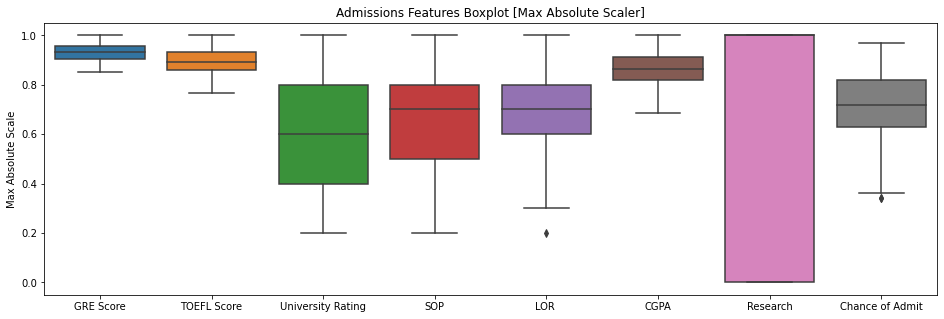

In [154]:
plt.figure(figsize=(16,5))
sns.boxplot(columns, [df_cleaned[x] for x in df_cleaned])
plt.title('Admissions Features Boxplot [Max Absolute Scaler]')
plt.ylabel('Max Absolute Scale')
plt.show()

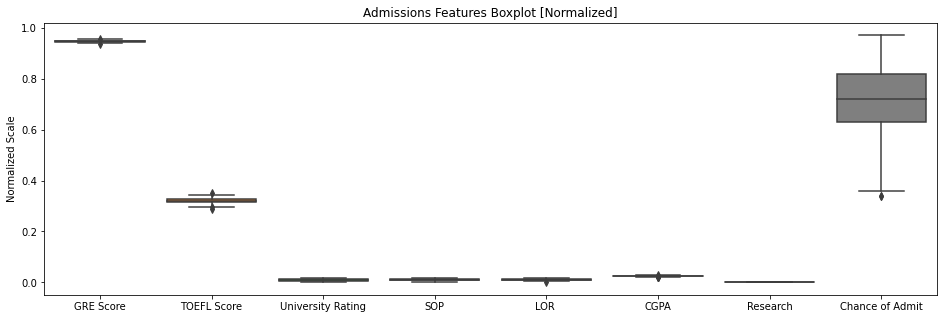

In [155]:
plt.figure(figsize=(16,5))
sns.boxplot(columns, [df_normalized[x] for x in df_normalized])
plt.title('Admissions Features Boxplot [Normalized]')
plt.ylabel('Normalized Scale')
plt.show()

As shown with the boxplots above, using a normalized preprocessing method skews the information too much based on if the values nearby all relatively large. For example, the GRE scores are all around the 300 range, this means that it will be high and the normalized values won't be representative of each candidates respective scores. This removes our ability to see the effect of the GRE Score feature. 

We will continue with both to see the differences between using both methods.

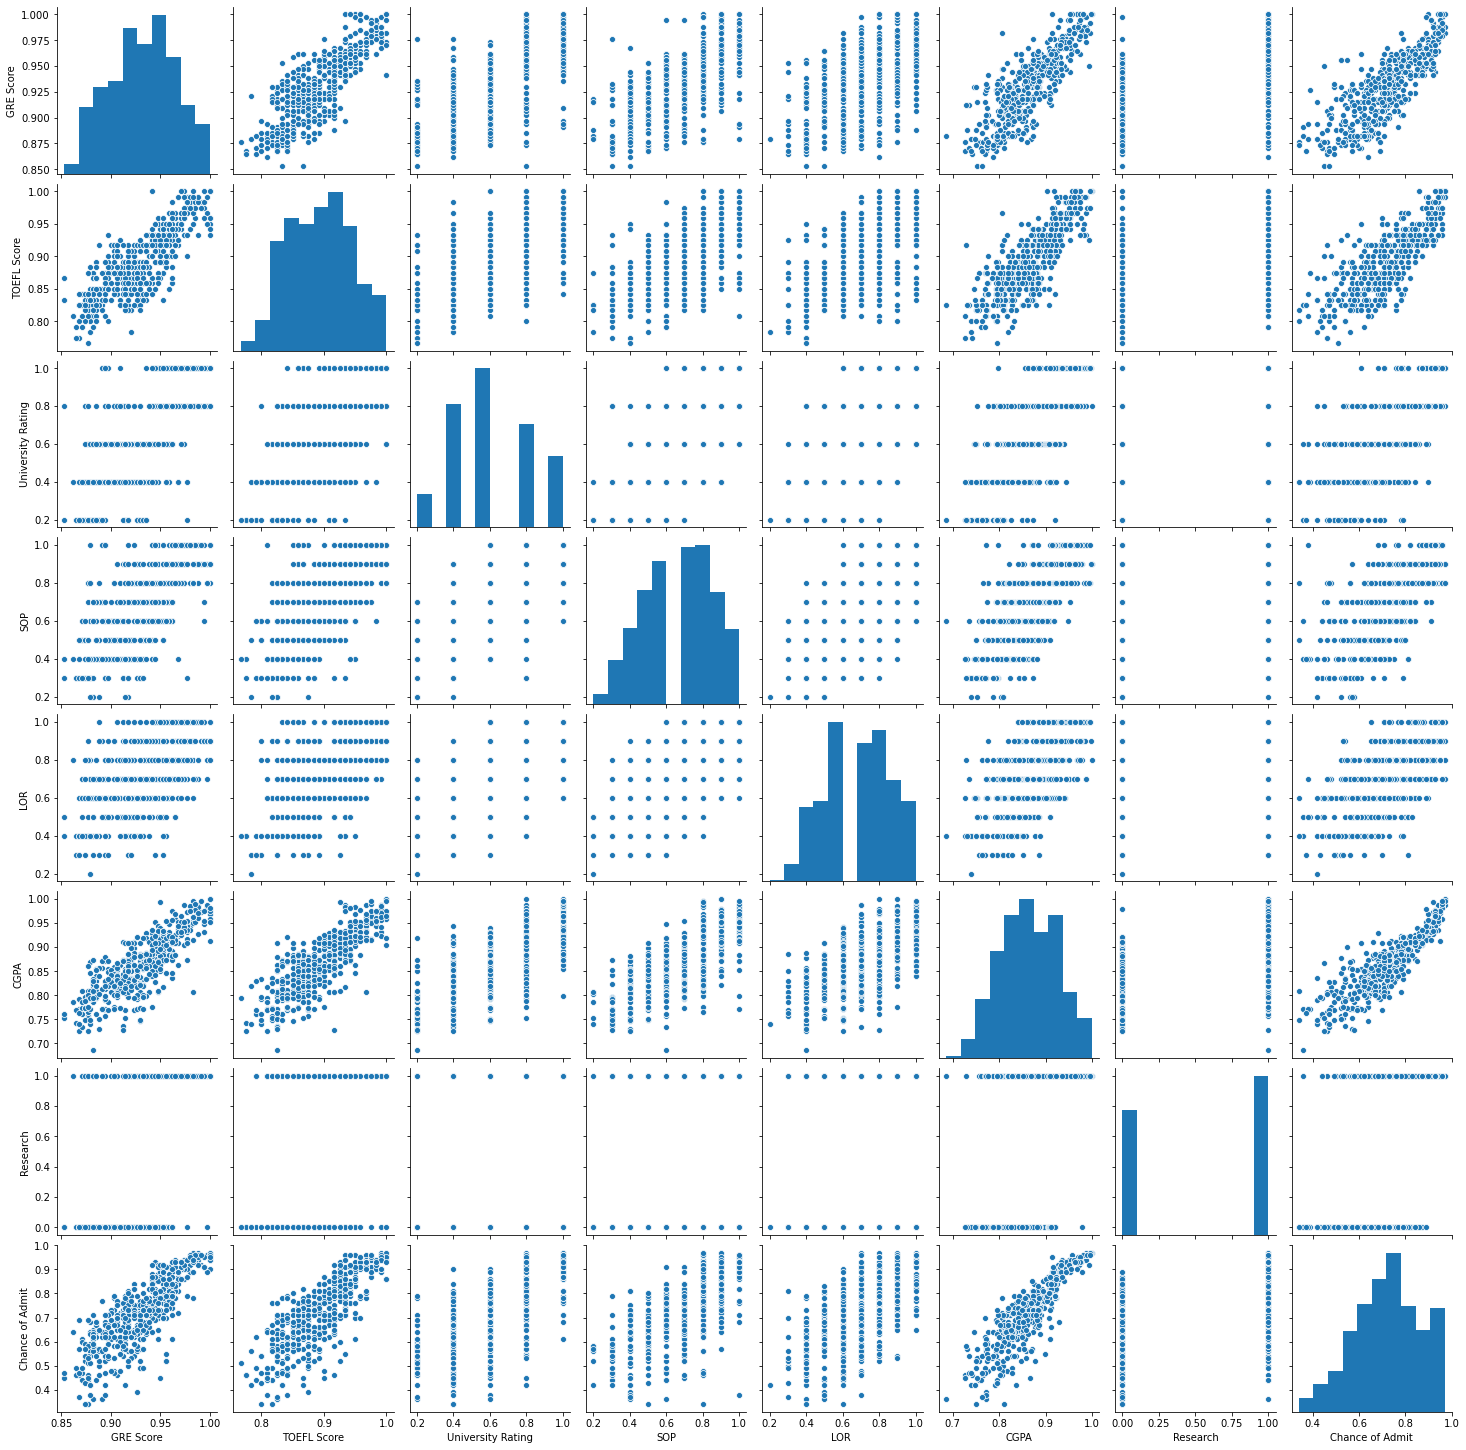

In [164]:
'''
As a quick look at a pairplot, it seems that the normalized values have a positive correlation with every other column. We 
can check the strength of the correlation by calculating for the Pearson coefficient for the columns in next cell.
'''

sns.pairplot(df_cleaned)
plt.show()

In [165]:
for column in columns:
    print("Pearson Score [{}]: {}".format(column, round(pearsonr(df_cleaned[column], df_cleaned['Chance of Admit'])[0],2)))

Pearson Score [GRE Score]: 0.81
Pearson Score [TOEFL Score]: 0.79
Pearson Score [University Rating]: 0.69
Pearson Score [SOP]: 0.68
Pearson Score [LOR ]: 0.65
Pearson Score [CGPA]: 0.88
Pearson Score [Research]: 0.55
Pearson Score [Chance of Admit]: 1.0


This test shows that the values have positive correlations and the highest contributor seems to be the CGPA and GRE score. This dataset's trends may hurt some who are trying to attend grad school, but might not have the best CGPA/GRE scores :(. Using the normalized values, we will see that it actually does not matter what GRE score you get (assuming you're within the range of this dataset)

The sanity check here is our knowledge of how GRE scores are often used in admissions processes and CGPAs are a slight indicator towrads student success. The second sanity check is that we expect the Pearson score for the "Chance to Admit" column to be 1.0 (as something's correlation to itself is 1).

In [166]:
for column in columns:
    print("Pearson Score [{}]: {}".format(column, round(pearsonr(df_normalized[column], df_normalized['Chance of Admit'])[0],2)))

Pearson Score [GRE Score]: -0.49
Pearson Score [TOEFL Score]: 0.47
Pearson Score [University Rating]: 0.64
Pearson Score [SOP]: 0.62
Pearson Score [LOR ]: 0.57
Pearson Score [CGPA]: 0.72
Pearson Score [Research]: 0.52
Pearson Score [Chance of Admit]: 1.0


Using the normalized value, we see that we lose the relationship between the GRE Score and the chance of admission. Our better judgement tells us that that feels wrong as GRE scores, like all standardized tests, are used to show competancy for students.

We will get back to this later.

## 3. Model Selection and Development


In this section, we will modify the shape of the data so that it is appropriate for sklearns' models. The steps in this process will always be: 
- Model Selection
- Label Selection (completed earlier)
- Train/Test Splitting of the Data
- Fitting
- Prediction

In [247]:
'''
This is the part where we need to split up the data between training data and testing data. We will force a random state
so that we can reproduce our findings if we discover any anomolies.
'''
train, test = train_test_split(df_cleaned, 
                           train_size = 0.8, 
                           random_state=0
                              )

In [248]:
'''
We split the training and testing data between their features and labels.
'''

X_train, X_test = train[columns[:7]], test[columns[:7]]
y_train, y_test = train['Chance of Admit'], test['Chance of Admit']

The reason why X and y are used is due to mathmatical conventions of X being an input matrix and y being an output vector. You may have seen this in math courses as this as well:

$ \vec{A} \dot{} \vec{x} = \vec{b} $ 

In [249]:
'''
We will approach this using the simplest approach, a linear regression. We will create a prediction 
on your chances of admission based off of your inputer information.
'''

linear = LinearRegression()

In [250]:
linear.fit(X_train, y_train)

LinearRegression()

In [251]:
'''
We are printing the R^2 value of the linear model based off of the testing dataset. We are getting
around 0.77 as our score This score means to show how well the model fits the data. Considering how
much variation there is in admission data (and even more that we can't see like essays), this is a
relatively good model for admissions prediction, but only in the scope of using numbers only. 
'''
linear_abs_R2 = linear.score(X_test, y_test)

print('Linear R^2:', linear.score(X_test, y_test))

Linear R^2: 0.7664048993199382


In [256]:
'''
We can also do this for the normalized values and see if we get a difference in model R^2 value.
'''

linear2 = LinearRegression()
train2, test2 = train_test_split(df_normalized, 
                           train_size = 0.8, 
                           random_state=0
                              )

X_train2, X_test2 = train2[columns[:7]], test2[columns[:7]]
y_train2, y_test2 = train2['Chance of Admit'], test2['Chance of Admit']

linear2.fit(X_train2, y_train2)

linear_norm_R2 = linear2.score(X_test2, y_test2)

print('Normalized R^2', round(linear2.score(X_test2, y_test2),3))


Normalized R^2 0.652


In [257]:
'''
This is a quick test to see the differences between the linear model and the actual values. Feel 
free to change the index value to see the differences between the two.
'''
index = 0

print(linear.predict([X_test.iloc[index]]))
print(y_test.iloc[index])

[0.5884545]
0.64


To further explore the impact of specific features, we can continue this process, but instead, we can omit a single feature and see how much of an effect it has on the $R^2$ value of our model. We will explore the variability of the response of the data in the next section using the normalized and absolute scaled datasets.

___

In [264]:
'''
Using the Absolute Scaler, we get these changed values. It seems that GRE score being removed doens't
have much effect to the accuracy of the model as previously believed.
'''

print('Abs R2: {}'.format(round(linear_abs_R2,3)))
for column in columns[:7]:
    df_model_testing = df_cleaned.loc[:, df_cleaned.columns != column]
    columns_minus_one = df_model_testing.columns
    
    train, test = train_test_split(df_model_testing, 
                               train_size = 0.8, 
                               random_state=0
                                  )

    X_train, X_test = train[columns_minus_one[:6]], test[columns_minus_one[:6]]
    y_train, y_test = train['Chance of Admit'], test['Chance of Admit']

    linear = LinearRegression()
    linear.fit(X_train, y_train)
    print('Linear without {}:'.format(column), round(linear.score(X_test, y_test),3))

Abs R2: 0.766
Linear without GRE Score: 0.769
Linear without TOEFL Score: 0.763
Linear without University Rating: 0.765
Linear without SOP: 0.766
Linear without LOR : 0.774
Linear without CGPA: 0.69
Linear without Research: 0.761


In [263]:
'''
Using the normalized values, we check the test with no columns removed and see that there is a
decrease in the R^2 value compared to the absolute scaler. 
'''
print('Normalized R2: {}'.format(round(linear_norm_R2,3)))
for column in columns[:7]:
    df_model_testing = df_normalized.loc[:, df_normalized.columns != column]
    columns_minus_one = df_model_testing.columns
    
    train, test = train_test_split(df_model_testing, 
                               train_size = 0.8, 
                               random_state=0
                                  )

    X_train, X_test = train[columns_minus_one[:6]], test[columns_minus_one[:6]]
    y_train, y_test = train['Chance of Admit'], test['Chance of Admit']

    linear = LinearRegression()
    linear.fit(X_train, y_train)
    print('Linear normalized without {}:'.format(column), round(linear.score(X_test, y_test),3))


Normalized R2: 0.652
Linear normalized without GRE Score: 0.653
Linear normalized without TOEFL Score: 0.653
Linear normalized without University Rating: 0.652
Linear normalized without SOP: 0.651
Linear normalized without LOR : 0.645
Linear normalized without CGPA: 0.594
Linear normalized without Research: 0.59


___

Wait a minute! Our previous intution seems to have given us the wrong assumption of the GRE Scores' relationship to your admissions' chance. It seems that there is no reasonable effect on the admissions chance using the methods that we have just used.

_Is it okay to just cherry pick whichever one tells our story better and move on with our lives?_

Of course the answer to this question is a resounding no! Our goal as ethical analysts is to not skew the data to fit a narrative that we'd like. Instead, we must change our viewpoints based off of the new data and findings that we see!

Using this realization, it seems that our $R^2$ value gets impacted the most when remove our CGPA from our linear model. We can then say that there is only a relationship between those two. 

___

Understanding the context of this dataset can motivate further investigation into several things:

- How much does one's CGPA affect their chances of admissions?
- Is GRE score simply used as a cutoff for admissions?
- Can we quantify other aspects of the admissions process (like essays) and tie them to admissions?

___

The best part about data analysis is that any finding that we have on our current dataset can always push us to deeper and more nuanced learnings of the data at hand. It is always good to keep in mind the context and anything missing from the overall dataset and to always challenge your biases with the data collected.

_* Note: We will not work on any deliverables for this dataset as our goal was to address biases we may have about the admissions process and use data to change or reinforce our biases._

## 4. Conclusion/Final Thoughts

Overall, this would be considered an incomplete dataset. While the information may seem complete, there are many nuances in the admissions process that these numbers simply do not encapsulate. This prevents us from drawing any conclusions with this dataset alone. 

_Do not be afraid to admit that the data you currently have is not enough. It is always better to be concise than to be fast._

I think the "Move Fast and Break Things" mentality pervades the approach that many have towards anything in tech. While it may be appropriate for development, data analysis and the field of data as a whole requires more rigor in the approach.

_Software can be rolled back. Misinformation cannot._

Please use this example of admissions to further explore any possible biases you may have. Things that seem to make sense might not always make sense when backed up by data. Always be thorough. Always be skeptical.